In [1]:
from utils import helper
import matplotlib.pyplot as plt
from IPython.display import display, HTML
plt.style.use("ggplot")

# define macros
ORIGINAL_DATA_PATH = '/home/brikerman/Desktop/corpus/殆知阁古代文献藏书/史藏'
TARGET_DATA_PATH = '/home/brikerman/Desktop/corpus/daizhige_split/史藏'

MAX_SEQUENCE_LENGTH = 100
EPOCHS = 5
BATCH_SIZE = 200

Using TensorFlow backend.


## 数据预处理

### 提取有标点的数据集

原数据没有区分那些数据是有标点，那些数据是没有标点。所以我们的第一部是区分有标点和没有标点的数据集。
目前这里采取了很简单粗暴的方案，看一篇文章中汉字和标点的比例，即 标点符号数量 / (汉字数量 + 标点符号数量) 当比例大于 0.1 则判断为有标点符号。

In [2]:
from utils import split_data
split_data.split_marked_unmarked_files(ORIGINAL_DATA_PATH, TARGET_DATA_PATH)

generating file info: 100%|██████████| 2043/2043 [02:18<00:00, 14.78it/s] 
copying files to /home/brikerman/Desktop/corpus/daizhige_split/史藏/marked: 100%|██████████| 1313/1313 [00:00<00:00, 2823.02it/s]
copying files to /home/brikerman/Desktop/corpus/daizhige_split/史藏/unmarked: 100%|██████████| 730/730 [00:00<00:00, 1682.21it/s]


In [3]:
# 读取文件信息 csv 并展示
import pandas as pd
df = pd.read_csv('./file_info.csv')
display(HTML(df.to_html()))

,Unnamed: 0,chinese_count,file,mark_count,mark_list,mark_rate,token_count
0,0,872358,/经世文编/皇朝经世文续编-清-饶玉成.txt,124426,） ， ？ ○ （ 、 。,0.124827,996784
1,1,2818854,/经世文编/皇朝经世文续编.txt,429037,【 ， ○ （ ） 。,0.132097,3247891
2,2,1134341,/经世文编/皇朝经世文新编续集.txt,1732,【 。 ： 》 】 ， ○ 《,0.001525,1136073
3,3,1750842,/经世文编/皇朝经世文续编-清-葛士浚.txt,1176,： 》 ○ 、 （ ） 《,0.000671,1752018
4,4,4065949,/经世文编/皇朝经世文统编.txt,1640,。 》 ， ○ 、 （ ） 《,0.000403,4067589
5,5,2400582,/经世文编/皇朝经世文编.txt,372857,， 、 ○ 。,0.134439,2773439
6,6,3815648,/经世文编/皇明经世文编.txt,526719,【 。 》 】 ， ？ ○ 、 （ ） 《,0.121298,4342367
7,7,1161836,/经世文编/皇朝经世文三编.txt,16,） ○ （,0.000014,1161852
8,8,473323,/经世文编/皇朝经世文编五集.txt,277,： ； 》 ， ○ 、 《 。,0.000585,473600
9,9,1254235,/经世文编/皇朝经世文新编.txt,66,。 》 ， ○ （ ） 《,0.000053,1254301


### 数据 token 化

这里我自己写了个 Tokenizer，支持直接 tokenize 数据或者利用预训练的词向量模型，关于如何预训练词向量我晚些时候补上。

In [2]:
import os
from utils.tokenizer import Tokenizer

# 构建 tokenizer，只需要构建一次
tokenizer = Tokenizer()
tokenizer.build(corpus_path=ORIGINAL_DATA_PATH, tokenizer_path='./data/embedding/')

# 加载 tokenizer 数据
tokenizer.load('./data/embedding/')

In [4]:
# token 化数据
marked_file_path = os.path.join(TARGET_DATA_PATH, 'marked')
tokenizer.max_length = MAX_SEQUENCE_LENGTH
files_info = tokenizer.tokenize_files(files_path=marked_file_path,
                                      data_path='./data')

processing files: 100%|██████████| 1313/1313 [02:20<00:00,  9.32it/s]

-------- tokenize data finished --------
dataset path : /home/brikerman/Desktop/classic_chinese_punctuate/data/dataset.h5
sample x     : [   1   90  324  261  103   60   21   13  120  118   73  131  159   16
  943  586 1698   36   13   23  118  103  131   21   60  134  167 2191
 1162   13  120  118   21  131  103   60  134  159   24  135   99   35
 3609 1704   41  535  798    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
sample y     : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1
 3 1 1 1 1 1 1 1 1 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
----------------------------------------


### 简单可视化分析数据长度

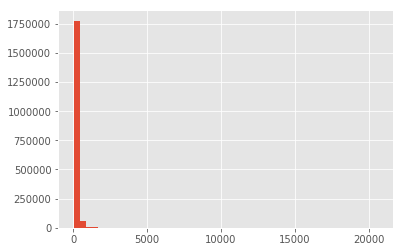

In [8]:
plt.hist(files_info['length'], bins=50)
plt.show()

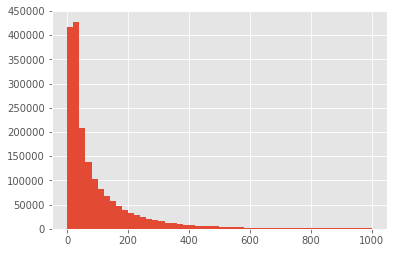

In [9]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist(files_info['length'], bins=50, range=(0, 1000))
plt.show()

## 构建模型

In [3]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import InputLayer
from keras.layers import Dropout
from keras.layers import Activation


if tokenizer.w2v:
    print('use pre embedded embedding layer')
    embedding_layer = Embedding(len(tokenizer.w2v.embedding_matrix),
                            tokenizer.w2v.embedding_size,
                            weights=[tokenizer.w2v.embedding_matrix],
                            trainable=False)
else:
    print('embed while training')
    embedding_layer = Embedding(len(tokenizer.word2idx), 50)

# custom loss fucntion with weights    
loss_f = helper.weighted_categorical_crossentropy(tokenizer.class_weights())

model = Sequential()
model.add(InputLayer(input_shape=(MAX_SEQUENCE_LENGTH, )))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(len(tokenizer.labels2idx))))
model.add(Activation('softmax'))
model.compile(loss=loss_f,
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

embed while training
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1062350   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 512)          628736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 17)           8721      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 17)           0         
Total params: 1,699,807
Trainable params: 1,699,807
Non-trainable params: 0
_________________________________________________________________


### 训练模型

In [ ]:
import h5py
from sklearn.model_selection import train_test_split

dataset = h5py.File('./data/dataset.h5', 'r')

train_idx, test_idx = train_test_split(range(len(dataset['x'])), test_size=0.15)

train_generator = helper.h5f_generator(h5path='./data/dataset.h5',
                                       indices=train_idx,
                                       label_count=len(tokenizer.labels2idx),
                                       batch_size=BATCH_SIZE)

test_generator = helper.h5f_generator(h5path='./data/dataset.h5',
                                      indices=test_idx,
                                      label_count=len(tokenizer.labels2idx),
                                      batch_size=BATCH_SIZE)

model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_idx) // BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[],
                    validation_data=test_generator,
                    validation_steps=len(test_idx) // BATCH_SIZE)


Epoch 1/5
4098/7857 [==============>...............] - ETA: 11:48 - loss: 0.2340 - acc: 0.9082

## 使用模型预测

In [19]:
for text in [
    '余谓拯饥之政富郑公在青州为百世师仿其意而行之在后贤焉兴赈田'
]:
    r = helper.predict_with_model(tokenizer=tokenizer, model=model, text=text)
    print(r)

余谓拯饥之政富郑公在青州为百世师仿其意而行之在后贤焉。兴赈田。


In [20]:
# detail
import keras
from keras.preprocessing import sequence


text = '余谓拯饥之政富郑公在青州为百世师仿其意而行之在后贤焉兴赈田'
# 先对数据进行简单过滤和截断
input_text = [i for i in text if helper.chinese_regex.match(i)]
input_text = input_text[:tokenizer.max_length-2]
print('input_text: {}'.format(input_text))

# token 化
input_token = tokenizer.tokenize(input_text)
print('input_token: {}'.format(input_token))

# padding 成为定长序列
input_x = keras.preprocessing.sequence.pad_sequences([input_token],
                                                         maxlen=tokenizer.max_length,
                                                         padding='post')
print('input_x: {}'.format(input_x))

# model 预测结果，一个 100 * 16 的 one hot 向量
predict_result = model.predict(input_x)[0]
print('predict_result: {}'.format(predict_result))

predict_idx = predict_result.argmax(1)
print('predict_idx: {}'.format(predict_idx))

labels = tokenizer.label_de_tokenize(predict_idx, length=len(input_text))
print('labels: {}'.format(labels))

input_text: ['余', '谓', '拯', '饥', '之', '政', '富', '郑', '公', '在', '青', '州', '为', '百', '世', '师', '仿', '其', '意', '而', '行', '之', '在', '后', '贤', '焉', '兴', '赈', '田']
input_token: [1, 134, 175, 2846, 1306, 7, 211, 787, 606, 71, 42, 596, 29, 11, 60, 183, 201, 2059, 15, 296, 18, 48, 7, 42, 51, 479, 412, 223, 1288, 281, 2]
input_x: [[   1  134  175 2846 1306    7  211  787  606   71   42  596   29   11
    60  183  201 2059   15  296   18   48    7   42   51  479  412  223
  1288  281    2    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
predict_result: [[6.6565025e-07 9.9152970e-01 2.3563933e-03 ... 4.9532740e-05
  1.9892918e-04 6.9119883e-06]
 [2.1671069e-05 8.9504457e-01 4.4994164e-02 ... 8.3